# Практическая работа №1
## Предварительная обработка данных
Выполнил: Терентьев Никита Александрович КИ21-16/1б
Вариант: 21
## Цель работы
Знакомство с основными задачами предварительной обработки исходных данных, изучение основных методов предварительной обработки данных, формирование навыков выполнения предварительной обработки исходных данных с помощью языка программирования Python.
## Задачи
Выполнение практической работы предполагает решение следующих задач:
1. Визуальный анализ исходных данных
2. Поиск аномальных значений
3. Поиск и восстановление отсутствующих значений
4. Преобразование данных
## Ход работы
Был произведён импорт необходимых библиотек.

In [1]:
import pandas as pd
import numpy as np
import sklearn.impute

from scipy.stats import sigmaclip
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from functions import build_bar_and_pie_chart, build_histogram_density_diagram, build_histogram

Произведено чтение файла и взятие нужных колонок из таблицы в соответствии с вариантом.

In [2]:
data = pd.read_excel(r"C:\Users\nikit\Desktop\Программирование\4 семестр\data_analysis_methods\1 lab\data\first_practice_dataframe.xlsx")
# Названия колонок датафрейма храним в константах
GENDER = "cat1_gender"
EDUCATION = "cat3_education"
NUM1 = "num1_22"
NUM2 = "num2_22"
NUM3 = "num3_22"
headers = [GENDER, EDUCATION, NUM1, NUM2, NUM3]
dataframe = pd.DataFrame(data[headers])
dataframe

,cat1_gender,cat3_education,num1_22,num2_22,num3_22
0,male,high school,311.628509,664.606363,648.5319
1,male,phd,88.551646,1001.232482,665.864398
2,male,School SAT,314.105165,806.071418,667.958668
3,NaN,BSc,-168.550590,987.065373,651.231183
4,male,phd,294.298042,1216.844021,645.612568
...,...,...,...,...,...
995,male,phd,-34.721255,NaN,619.945966
996,male,phd,-55.516395,858.140616,637.922461
997,male,phd,-43.164240,717.465601,675.80899
998,NaN,phd,-220.999640,1001.632875,NaN


### 1. Визуальный анализ данных
Были построены графики для визуального представления каждого столбца(признака) в исходном наборе данных.
Все функции для построения графиков были вынесены в отдельный файл functions.py

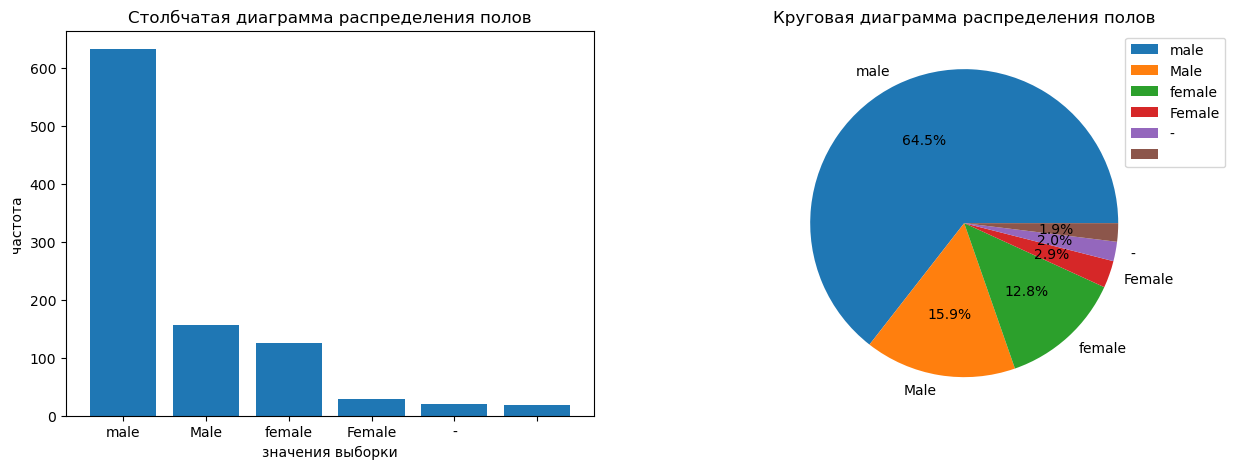

In [3]:
build_bar_and_pie_chart(dataframe, GENDER, "полов")

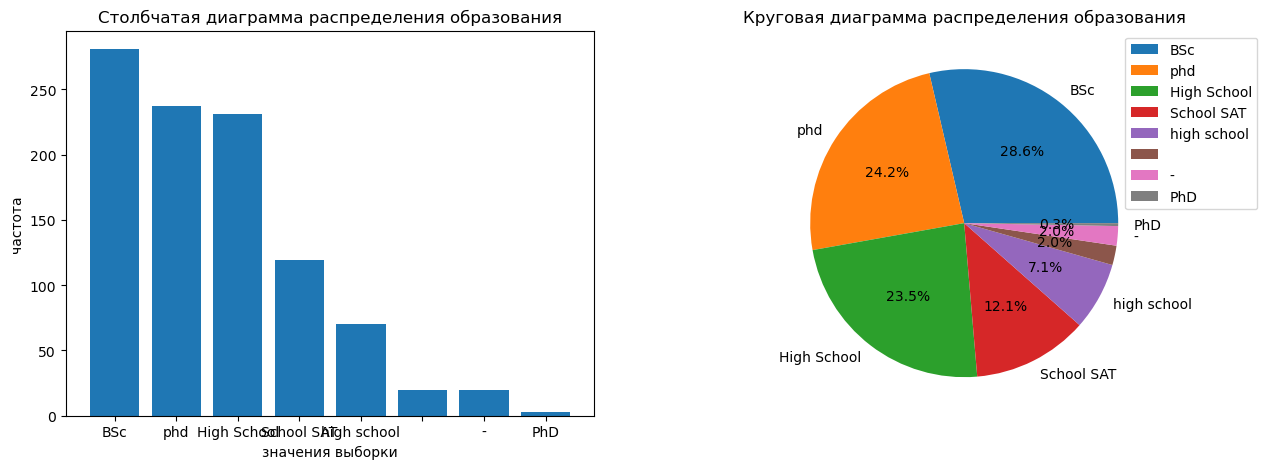

In [4]:
build_bar_and_pie_chart(dataframe, EDUCATION, "образования")

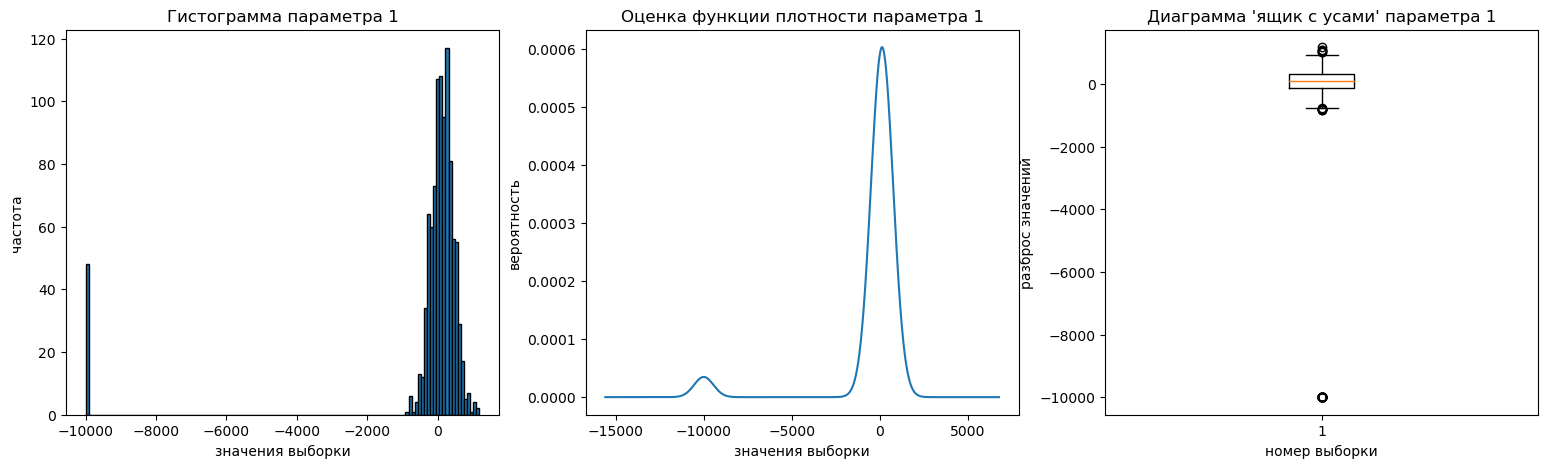

In [5]:
build_histogram_density_diagram(dataframe, NUM1, "1")

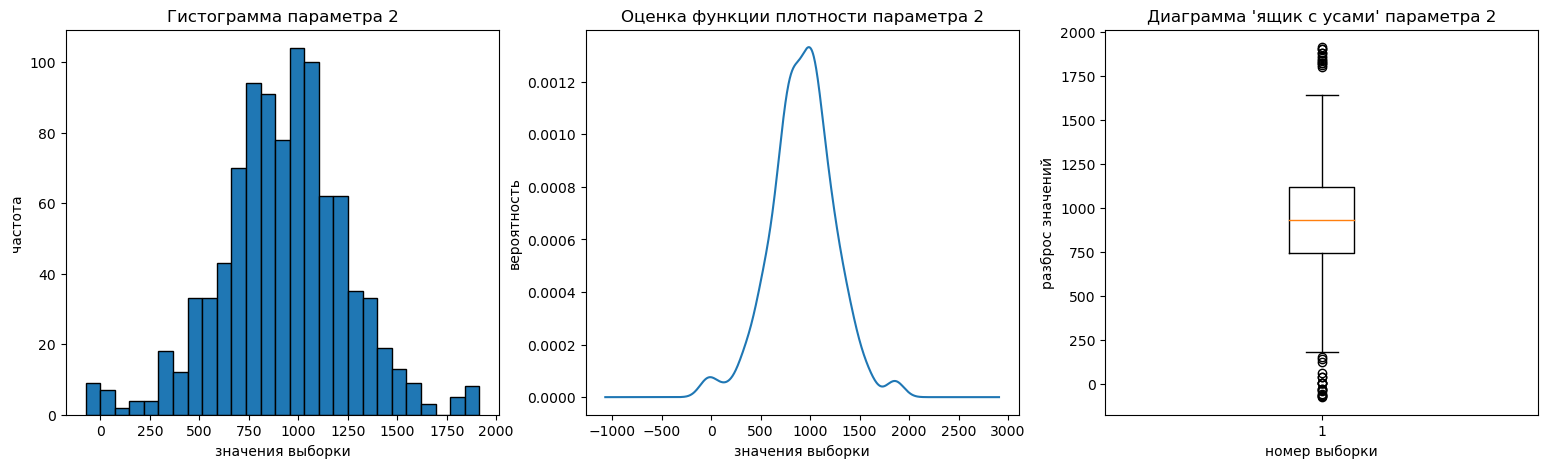

In [6]:
build_histogram_density_diagram(dataframe, NUM2, "2")

График не может быть построен, так как столбец содержит не только числовые значения.


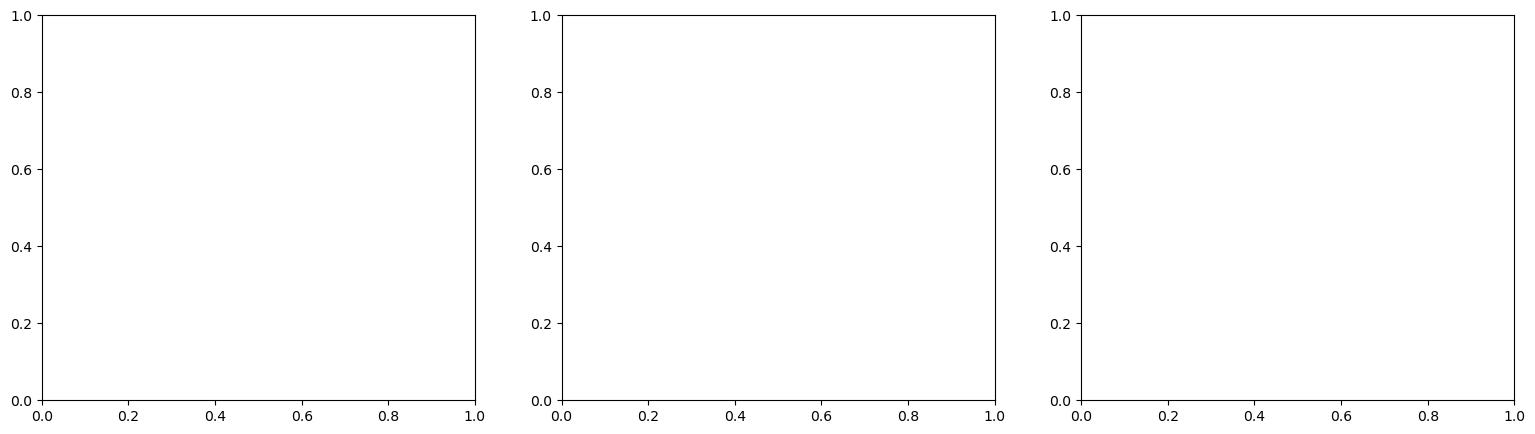

In [7]:
try:
    build_histogram_density_diagram(dataframe, NUM3, "3")
except TypeError:
    print("График не может быть построен, так как столбец содержит не только числовые значения.")

### 2. Проверка правдоподобности исходных данных
Проанализировав полученные графики, можно сделать вывод, что некоторые значения из таблицы являются некорректными (например, пропуски значений). Метод info позволяет увидеть, что некоторые колонки имеют неверный тип.

In [8]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   cat1_gender     982 non-null    object 
 1   cat3_education  981 non-null    object 
 2   num1_22         1000 non-null   float64
 3   num2_22         951 non-null    float64
 4   num3_22         974 non-null    object 
dtypes: float64(2), object(3)
memory usage: 39.2+ KB


#### Изменение качественных признаков
Выводим уникальные значения, содержащиеся в каждом столбце, чтобы понимать то, каким образом будет производиться чистка данных.

In [9]:
dataframe.cat1_gender.unique()

array(['male', nan, 'female', 'Male', '-', 'Female', ' '], dtype=object)

In [10]:
dataframe.cat3_education.unique()

array(['high school', 'phd', 'School SAT', 'BSc', 'High School', ' ', nan,
       '-', 'PhD'], dtype=object)

Приведём найденные значения к нужному формату (всем пустым значениям был присвоен тип None, признаки, отличающиеся типом написания, были приведены к одному виду).

In [11]:
dataframe[GENDER].replace(to_replace=[" ", "-", "", np.nan], value=None, inplace=True)
dataframe[GENDER].replace(to_replace="male", value="Male", inplace=True)
dataframe[GENDER].replace(to_replace="female", value="Female", inplace=True)

In [12]:
dataframe[EDUCATION].replace(to_replace=[" ", "-", "", np.nan], value=None, inplace=True)
dataframe[EDUCATION].replace(to_replace="high school", value="High School", inplace=True)
dataframe[EDUCATION].replace(to_replace="phd", value="PhD", inplace=True)

Первая и вторая колонка были приведены к категориальному типу.

In [13]:
dataframe[GENDER] = dataframe[GENDER].astype("category")
dataframe[EDUCATION] = dataframe[EDUCATION].astype("category")

#### Изменение количественных признаков

In [14]:
dataframe.num3_22.apply(lambda x: x if not isinstance(x, float) else None).unique()

array([None, ' ', '-'], dtype=object)

In [15]:
dataframe[NUM3].replace(to_replace=[" ", "-", "", None], value=np.nan, inplace=True)

Был построен ряд графиков исходя из обновленных значений последнего столбца.

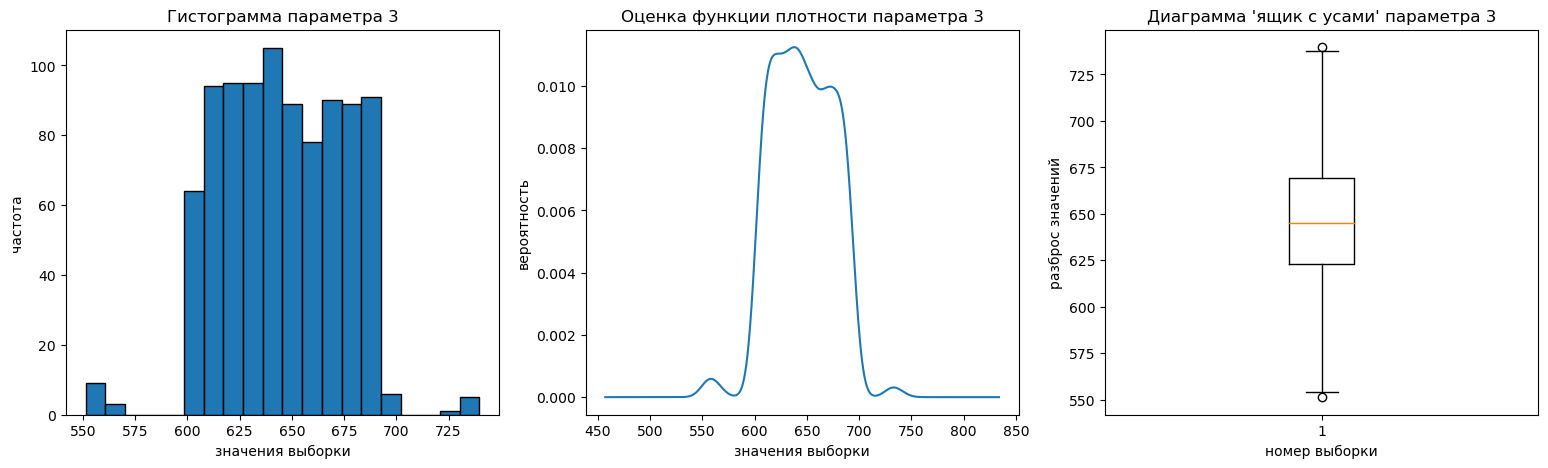

In [16]:
build_histogram_density_diagram(dataframe, NUM3, "3")

Все данные были приведены к нужному формату. Все качественные признаки имеют тип category, все количественные - float64.

In [17]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   cat1_gender     943 non-null    category
 1   cat3_education  941 non-null    category
 2   num1_22         1000 non-null   float64 
 3   num2_22         951 non-null    float64 
 4   num3_22         914 non-null    float64 
dtypes: category(2), float64(3)
memory usage: 25.8 KB


### 4. Поиск и восстановление пропущенных значений
Пропуски значений будут заменены значениями, полученными с помощью метода "k-ближайших соседей".
Для начала были выведены значения и их количество в столбце.

In [18]:
dataframe[GENDER].value_counts()

Male      789
Female    154
Name: cat1_gender, dtype: int64

Значения первого признака были преобразованы к числовым кодам.

In [19]:
label_encoder = LabelEncoder()
dataframe[GENDER] = label_encoder.fit_transform(dataframe[GENDER])
dataframe[GENDER].value_counts()

1    789
0    154
2     57
Name: cat1_gender, dtype: int64

Вывод функции value_counts позволяет увидеть, что значениям типа None был присвоен числовой код 2. Преобразуем их обратно к типу None и заменим значениями, полученными методом "k-ближайших соседей".

In [20]:
dataframe[GENDER].replace(to_replace=2, value=None, inplace=True)
dataframe_copy = dataframe.copy()
knn_inputer = sklearn.impute.KNNImputer()
inputed_dataframe = knn_inputer.fit_transform(dataframe_copy[[GENDER, NUM1, NUM2, NUM3]])
dataframe[GENDER] = inputed_dataframe[:, 0]
dataframe[GENDER] = dataframe[GENDER].apply(
    lambda x: round(x) # Округляем значения до целого числа
)
print(dataframe[GENDER].value_counts())
dataframe[GENDER]

1    843
0    157
Name: cat1_gender, dtype: int64


0      1
1      1
2      1
3      1
4      1
      ..
995    1
996    1
997    1
998    1
999    1
Name: cat1_gender, Length: 1000, dtype: int64

In [21]:
dataframe[GENDER] = label_encoder.inverse_transform(dataframe[GENDER])
dataframe[GENDER].value_counts()

Male      843
Female    157
Name: cat1_gender, dtype: int64

Пропуски значений второго признака были заменены самым популярным значением.

In [22]:
print(dataframe[EDUCATION].value_counts())

High School    301
BSc            281
PhD            240
School SAT     119
Name: cat3_education, dtype: int64


In [23]:
dataframe[EDUCATION] = dataframe[EDUCATION].fillna("High School")

Пропуски значений четвёртого признака были заменены медианой.

In [24]:
median = dataframe[NUM2].median()
dataframe[NUM2] = dataframe[NUM2].fillna(median)

Пропуски значений пятого признака были заменены значениями, полученными методом "k-ближайших соседей".

In [25]:
# Делаем копию датафрейма, чтобы сохранить значение колонок
frame_copy = dataframe.copy()
inputed_dataframe = knn_inputer.fit_transform(frame_copy[[NUM1, NUM2, NUM3]])
dataframe[NUM3] = inputed_dataframe[:, 2]

Все значения были восстановлены.

In [26]:
dataframe.count()

cat1_gender       1000
cat3_education    1000
num1_22           1000
num2_22           1000
num3_22           1000
dtype: int64

### 3. Поиск аномальных значений
Было произведено копирование датафрейма, чтобы можно было в дальнейшем сравнить два метода.

In [27]:
dataframe_copy = dataframe.copy()
dataframe_sigma = dataframe.copy()
dataframe_quantile = dataframe.copy()

#### Метод сигм
Были найдены значения для 1 числового параметра, резко отличающиеся от других (выбросы). Строки с найденными выбросами были удалены из датафрейма.

In [28]:
_, low, upp = sigmaclip(dataframe_sigma[NUM1], 3, 3)
dropped_values = dataframe_sigma[NUM1][(dataframe_sigma[NUM1] < low) | (dataframe_sigma[NUM1] > upp)]
dataframe_sigma = dataframe_sigma.drop(dropped_values.index, axis=0)

Таким же образом были удалены выбросы для 2 и 3 количественного параметра. Так как функция sigmaclip работает некорректно со значениями типа nan, было принято решение заменять их нулями.

In [29]:
_, low, upp = sigmaclip(dataframe_sigma[NUM2], 3, 3)
dropped_values = dataframe_sigma[NUM1][(dataframe_sigma[NUM2] < low) | (dataframe_sigma[NUM2] > upp)]
dataframe_sigma = dataframe_sigma.drop(dropped_values.index)

In [30]:
_, low, upp = sigmaclip(dataframe_sigma[NUM3], 3, 3)
dropped_values = dataframe_sigma[NUM1][(dataframe_sigma[NUM3] < low) | (dataframe_sigma[NUM3] > upp)]
dataframe_sigma = dataframe_sigma.drop(dropped_values.index)

In [31]:
dataframe_sigma.count()

cat1_gender       893
cat3_education    893
num1_22           893
num2_22           893
num3_22           893
dtype: int64

#### Метод квантилей

In [32]:
def quartile_method(data_frame, column):
    q25 = data_frame[column].quantile(0.25)
    q75 = data_frame[column].quantile(0.75)
    delta = q75 - q25
    inside_border = [(q25 - 1.5 * delta), (q75 + 1.5 * delta)] # Незначительный выброс
    # outside_border = [(q25 - 3 * delta), (q75 + 3 * delta)] # Значительный выброс
    return inside_border

In [33]:
low, high = quartile_method(dataframe_quantile, NUM1)
dropped_values = dataframe_quantile[NUM1][(dataframe_quantile[NUM1] < low) | (dataframe_quantile[NUM1] > high)]
dataframe_quantile = dataframe_quantile.drop(dropped_values.index)

In [34]:
low, high = quartile_method(dataframe_quantile, NUM2)
dropped_values = dataframe_quantile[NUM2][(dataframe_quantile[NUM2] < low) | (dataframe_quantile[NUM2] > high)]
dataframe_quantile = dataframe_quantile.drop(dropped_values.index)
low, high = quartile_method(dataframe_quantile, NUM3)
dropped_values = dataframe_quantile[NUM3][(dataframe_quantile[NUM3] < low) | (dataframe_quantile[NUM3] > high)]
dataframe_quantile = dataframe_quantile.drop(dropped_values.index)
dataframe_quantile.count()

cat1_gender       896
cat3_education    896
num1_22           896
num2_22           896
num3_22           896
dtype: int64

Использование метода сигм позволило удалить 107 выбросов из датафрейма, а метода квантилей - 104 выброса. Используем результаты очистки данных, полученных с помощью метода сигм.

In [35]:
dataframe = dataframe_sigma

Были построены гистограммы количественных признаков, очищенных от выбросов.

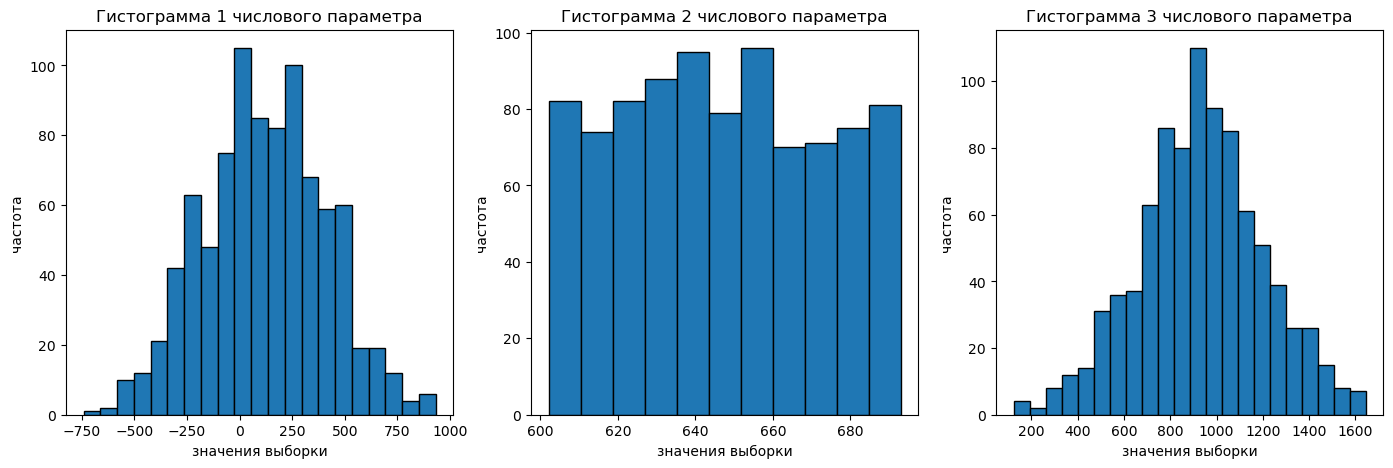

In [36]:
build_histogram(dataframe, NUM1, NUM2, NUM3)

### 5. Преобразование данных
#### Кодировка категориальных признаков
Было выполнена кодировка первого категориального признака с помощью one-hot encoding.

In [37]:
onehot_encoder = OneHotEncoder()
encoded_categorical_columns = pd.DataFrame(onehot_encoder.fit_transform(dataframe[[GENDER]]).toarray(), columns=dataframe[GENDER].unique())
dataframe = dataframe.join(encoded_categorical_columns)
dataframe

,cat1_gender,cat3_education,num1_22,num2_22,num3_22,Male,Female
0,Male,High School,311.628509,664.606363,648.531900,0.0,1.0
1,Male,PhD,88.551646,1001.232482,665.864398,0.0,1.0
2,Male,School SAT,314.105165,806.071418,667.958668,0.0,1.0
3,Male,BSc,-168.550590,987.065373,651.231183,0.0,1.0
4,Male,PhD,294.298042,1216.844021,645.612568,0.0,1.0
...,...,...,...,...,...,...,...
994,Male,School SAT,3.329050,932.614576,649.647338,NaN,NaN
995,Male,PhD,-34.721255,932.614576,619.945966,NaN,NaN
996,Male,PhD,-55.516395,858.140616,637.922461,NaN,NaN
997,Male,PhD,-43.164240,717.465601,675.808990,NaN,NaN


Для второго категориального признака была произведена кодировка при помощи label encoding.

In [38]:
dataframe[EDUCATION] = label_encoder.fit_transform(dataframe[EDUCATION])
dataframe[EDUCATION].value_counts()

1    322
0    254
2    211
3    106
Name: cat3_education, dtype: int64

#### Преобразование количественных признаков
В нормализованном наборе данных значения находятся между 0 и 1. Стандартизированный набор данных имеет нулевое среднее значение и единичную дисперсию (стандартное отклонение). Первый и второй количественный признак были приведены к нормализованному виду.

In [39]:
min_max_scaler = MinMaxScaler()
scaled_values = min_max_scaler.fit_transform(dataframe[[NUM1, NUM2]])
dataframe[["num1_scaled", "num2_scaled"]] = scaled_values

Третий количественный признак был приведён к стандартизированному виду.

In [40]:
standart_scaler = StandardScaler()
scaled_values = standart_scaler.fit_transform(dataframe[[NUM3]])
dataframe["num3_scaled"] = scaled_values
dataframe.head(6)

,cat1_gender,cat3_education,num1_22,num2_22,num3_22,Male,Female,num1_scaled,num2_scaled,num3_scaled
0,Male,1,311.628509,664.606363,648.531900,0.0,1.0,0.629187,0.355773,0.062124
1,Male,2,88.551646,1001.232482,665.864398,0.0,1.0,0.495883,0.577079,0.732924
2,Male,3,314.105165,806.071418,667.958668,0.0,1.0,0.630667,0.448775,0.813976
3,Male,0,-168.550590,987.065373,651.231183,0.0,1.0,0.342247,0.567765,0.166591
4,Male,2,294.298042,1216.844021,645.612568,0.0,1.0,0.618831,0.718827,-0.050860
5,Female,2,-154.589453,1143.103406,646.201688,1.0,0.0,0.350589,0.670348,-0.028060


## Выводы
В ходе работы были изучены основные задачи предварительной обработки исходных данных и методы предварительной обработки данных. Был произведён визуальный анализ исходных данных, поиск аномальных значений, восстановление отсутствующих значений и преобразование данных. Ниже произведено сравнение графиков, построенных по исходным данным и по полученным в результате работы обработанным данным.

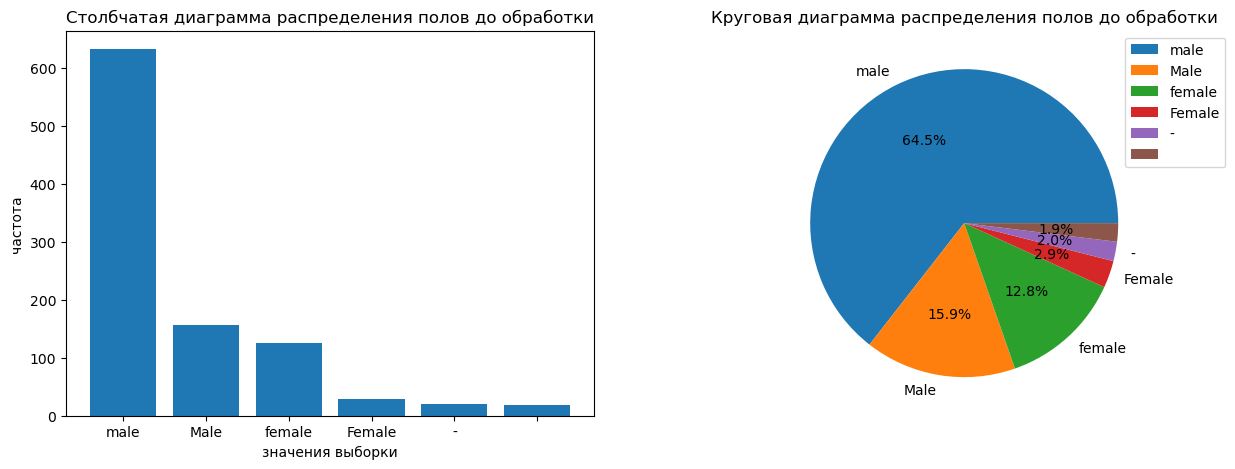

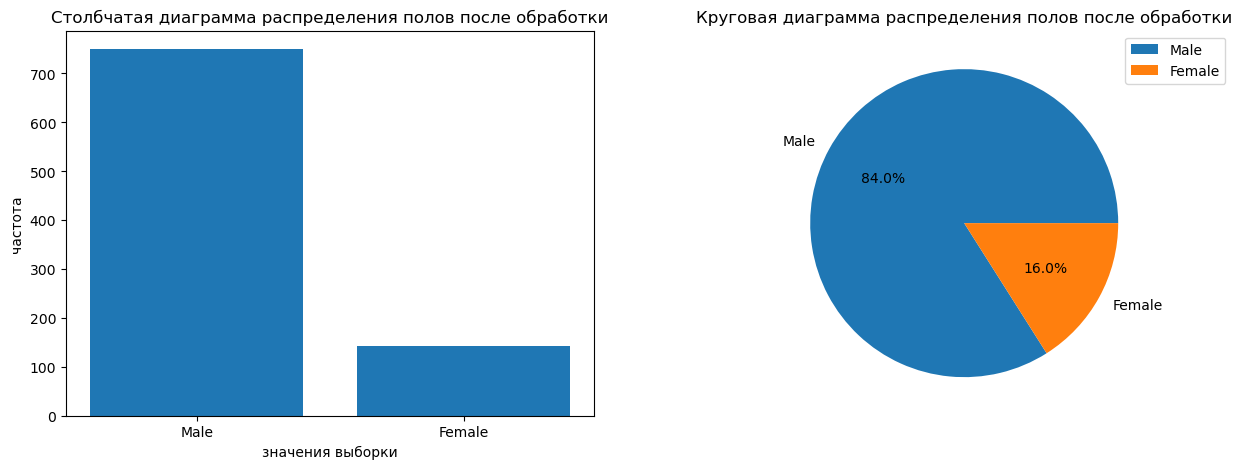

In [41]:
build_bar_and_pie_chart(data, GENDER, "полов до обработки")
build_bar_and_pie_chart(dataframe, GENDER, "полов после обработки")

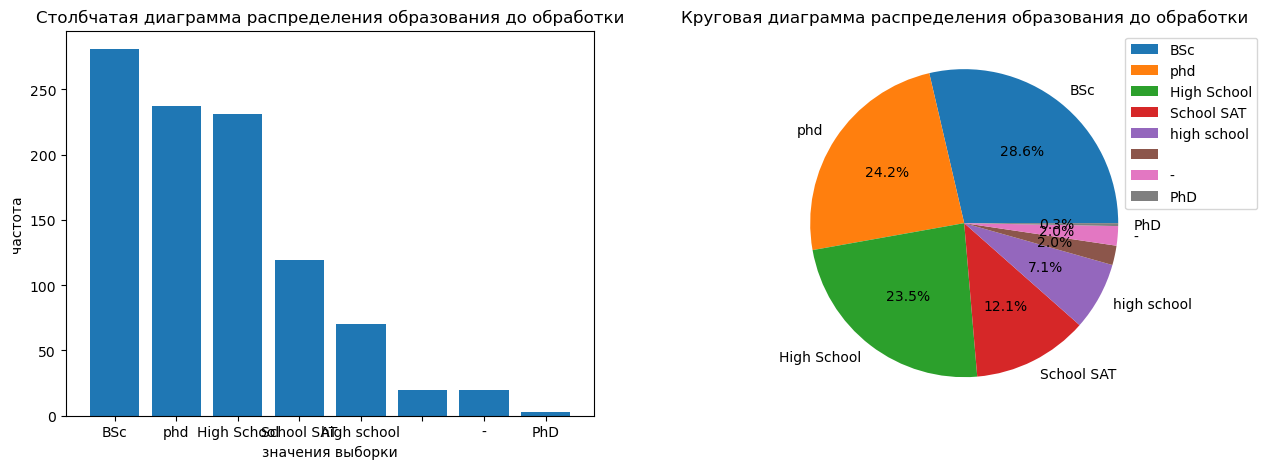

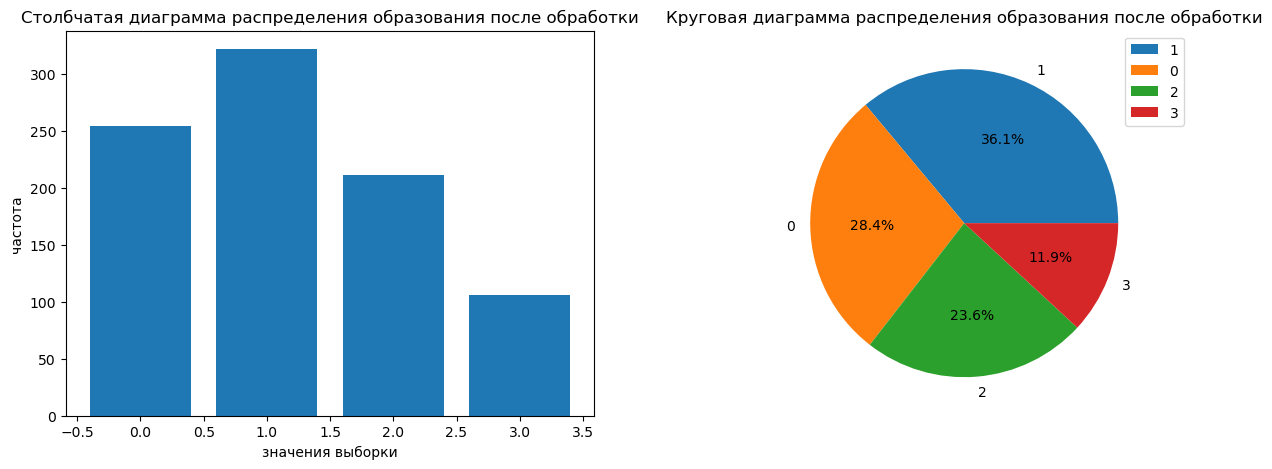

In [42]:
build_bar_and_pie_chart(data, EDUCATION, "образования до обработки")
build_bar_and_pie_chart(dataframe, EDUCATION, "образования после обработки")

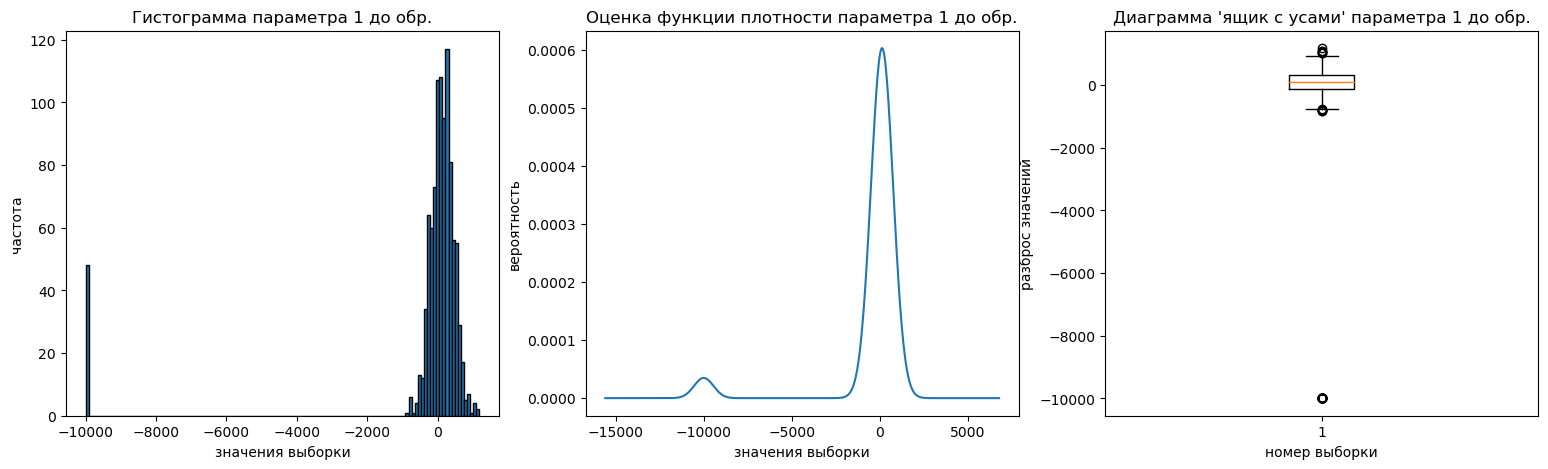

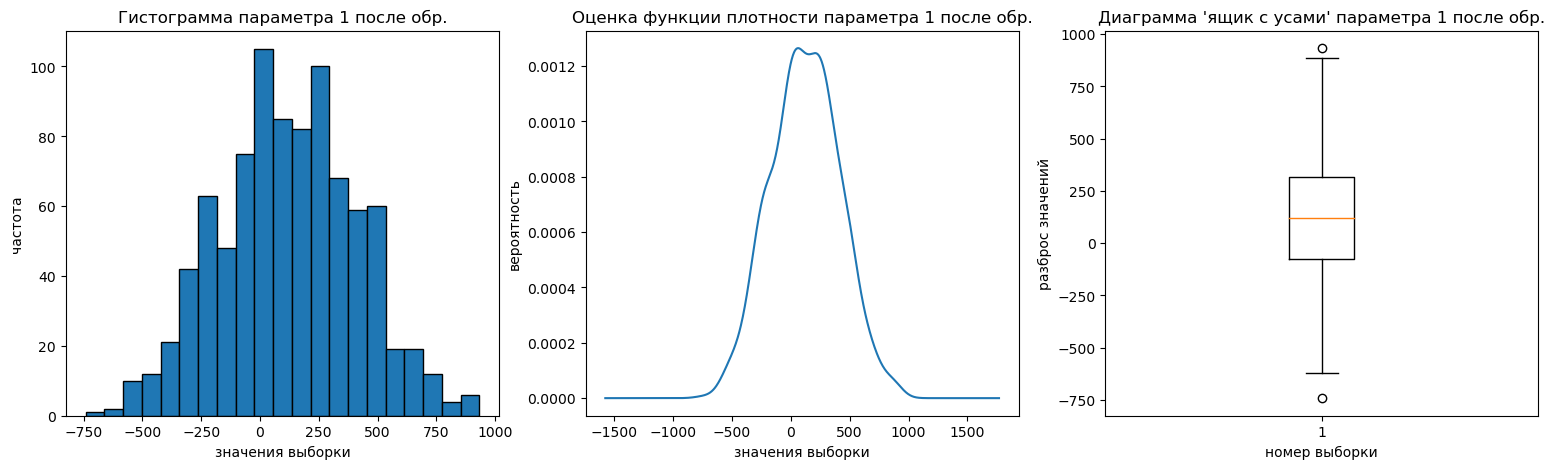

In [43]:
build_histogram_density_diagram(data, NUM1, "1 до обр.")
build_histogram_density_diagram(dataframe, NUM1, "1 после обр.")

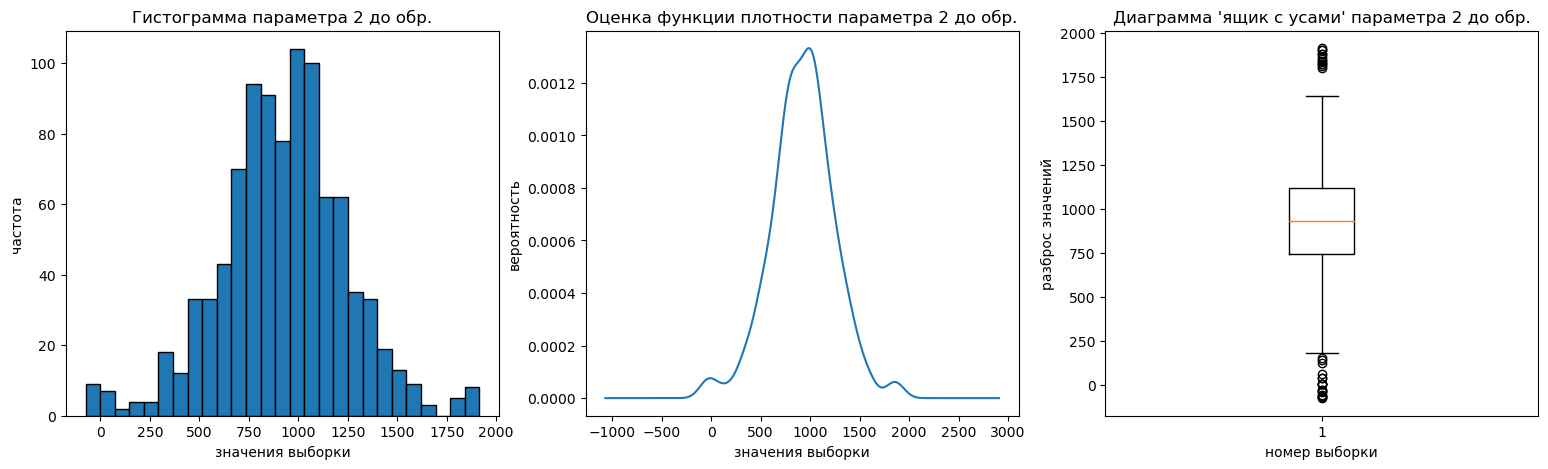

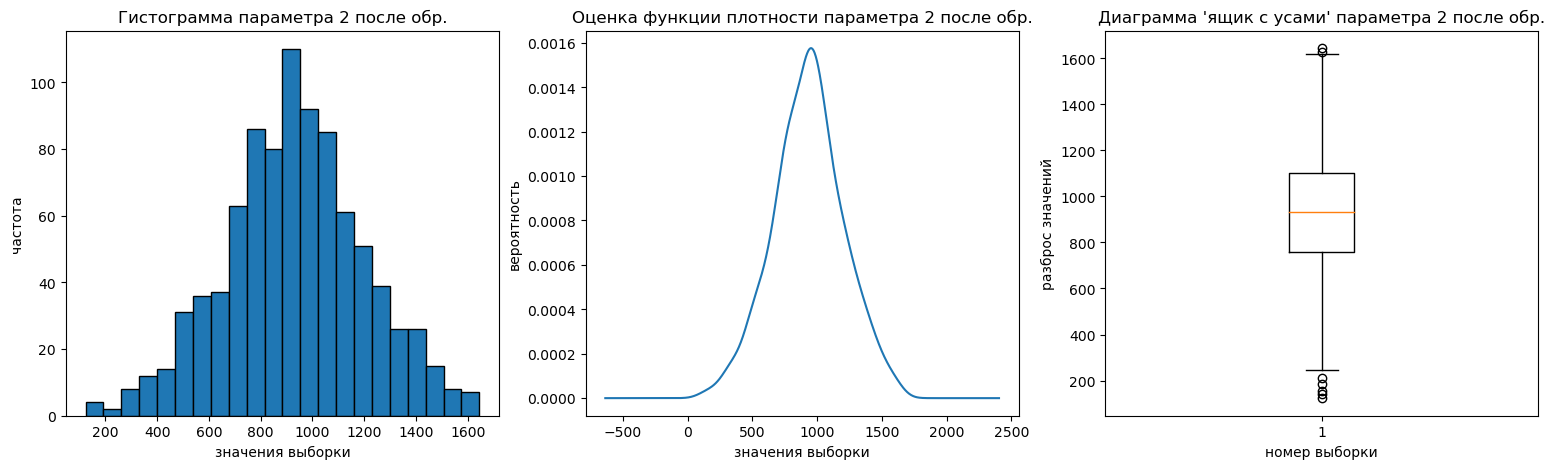

In [44]:
build_histogram_density_diagram(data, NUM2, "2 до обр.")
build_histogram_density_diagram(dataframe, NUM2, "2 после обр.")

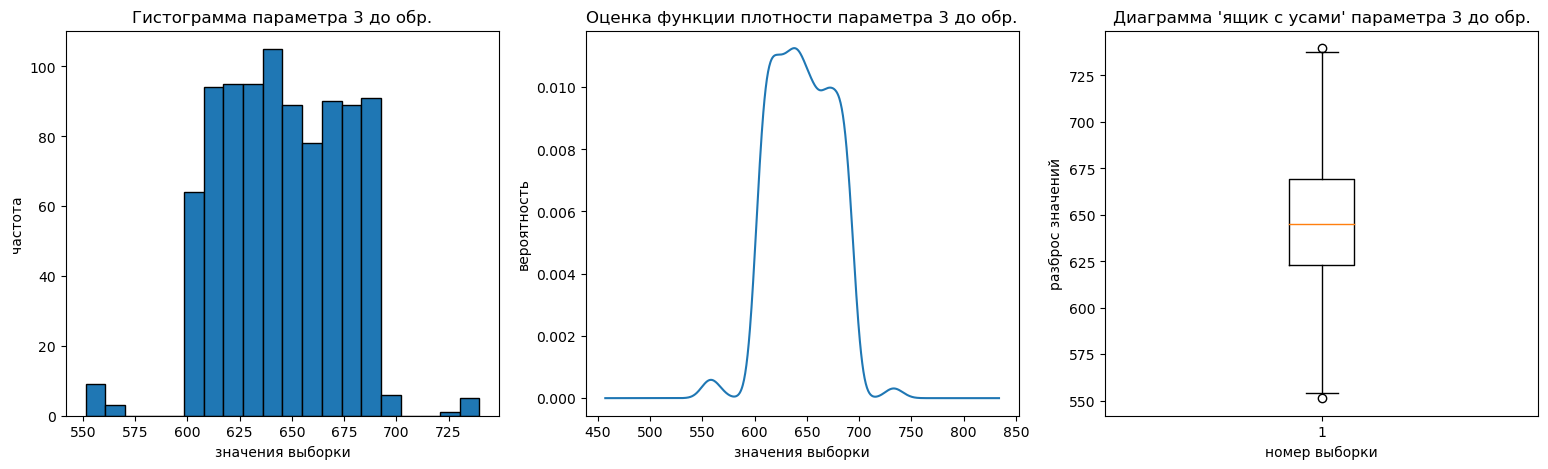

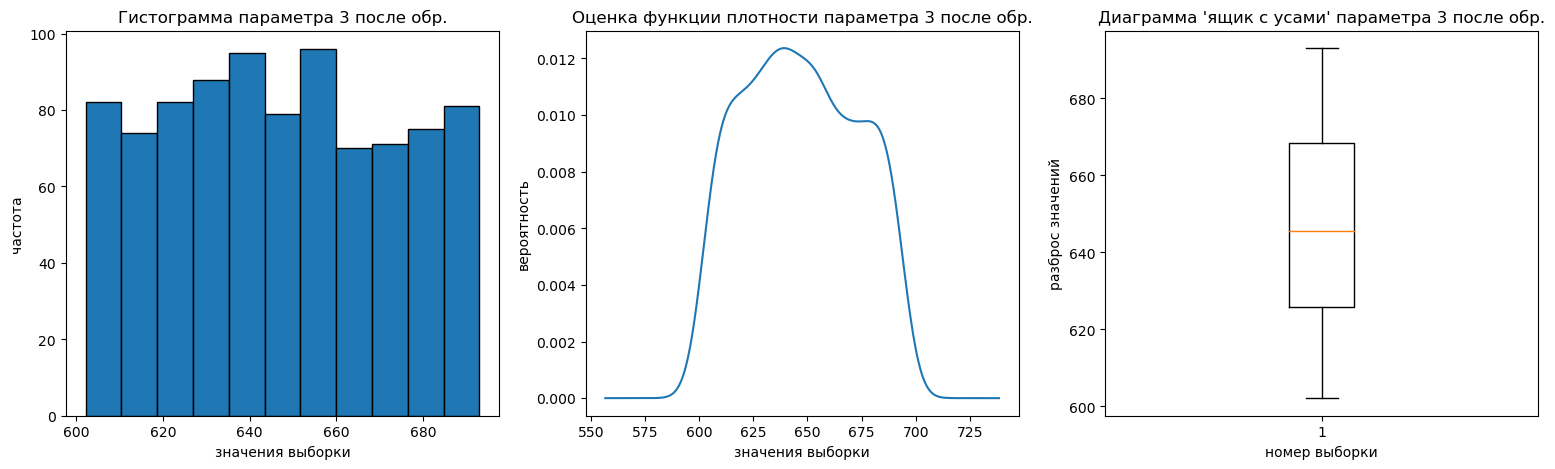

In [45]:
data[NUM3].replace(to_replace=[" ", "-", "", None], value=np.nan, inplace=True)
build_histogram_density_diagram(data, NUM3, "3 до обр.")
build_histogram_density_diagram(dataframe, NUM3, "3 после обр.")